<a href="https://colab.research.google.com/github/yahelrl19/ParkingLotProject/blob/main/ParkingLotProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parking Lot Project

Link: https://paperswithcode.com/paper/revising-deep-learning-methods-in-parking-lot

GitHub: https://github.com/eighonet/parking-research

Dataset: https://www.kaggle.com/datasets/braunge/aerial-view-car-detection-for-yolov5/data


Empezaremos descargando el dataset de Kaggle

In [1]:
# Paso 1: Instalar las dependencias necesarias
!pip install torch torchvision opencv-python matplotlib -q
!pip install kaggle -q

# Paso 2: Subir el archivo kaggle.json
from google.colab import files

print("Sube tu archivo kaggle.json")
files.upload()

# Paso 3: Configurar Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verificar que la API esté configurada correctamente
!kaggle datasets list

# Descargar el dataset desde Kaggle
!kaggle datasets download -d braunge/aerial-view-car-detection-for-yolov5

# Descomprimir el dataset
!unzip aerial-view-car-detection-for-yolov5.zip -d ./dataset

Sube tu archivo kaggle.json


Saving kaggle.json to kaggle.json
ref                                                          title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
bhadramohit/customer-shopping-latest-trends-dataset          Customer Shopping (Latest Trends) Dataset      76KB  2024-11-23 15:26:12           4104         78  1.0              
hopesb/student-depression-dataset                            Student Depression Dataset.                   454KB  2024-11-22 17:56:03           1843         34  0.9411765        
ikynahidwin/depression-student-dataset                       Depression Student Dataset                      4KB  2024-11-20 06:42:01           3564         72  1.0              
steve1215rogg/student-lifestyle-dataset                      student li

Visualización y exploración del dataset

In [2]:
# Directorios de imágenes y etiquetas
train_images_dir = './dataset/mydata/mydata/images/train'
train_labels_dir = './dataset/mydata/mydata/labels/train'

test_images_dir = './dataset/mydata/mydata/images/test'
test_labels_dir = './dataset/mydata/mydata/labels/test'

# Verificar que los directorios contienen datos
import os

print(f"Imágenes de entrenamiento: {len(os.listdir(train_images_dir))}")
print(f"Etiquetas de entrenamiento: {len(os.listdir(train_labels_dir))}")

print(f"Imágenes de prueba: {len(os.listdir(test_images_dir))}")
print(f"Etiquetas de prueba: {len(os.listdir(test_labels_dir))}")

Imágenes de entrenamiento: 280
Etiquetas de entrenamiento: 280
Imágenes de prueba: 19
Etiquetas de prueba: 19


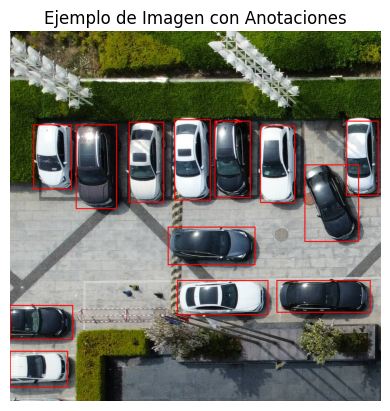

In [3]:
import cv2
import matplotlib.pyplot as plt

# Listar imágenes y etiquetas
train_image_files = sorted(os.listdir(train_images_dir))
train_label_files = sorted(os.listdir(train_labels_dir))

# Cargar una imagen de muestra
sample_image_path = os.path.join(train_images_dir, train_image_files[0])
sample_label_path = os.path.join(train_labels_dir, train_label_files[0])

# Leer la imagen
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Leer la etiqueta (formato YOLO)
with open(sample_label_path, 'r') as f:
    labels = f.readlines()

# Dibujar las cajas delimitadoras
h, w, _ = image.shape
for label in labels:
    class_id, x_center, y_center, width, height = map(float, label.strip().split())
    x1 = int((x_center - width / 2) * w)
    y1 = int((y_center - height / 2) * h)
    x2 = int((x_center + width / 2) * w)
    y2 = int((y_center + height / 2) * h)
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Mostrar la imagen con las cajas
plt.imshow(image)
plt.axis('off')
plt.title("Ejemplo de Imagen con Anotaciones")
plt.show()

# Estadísticas del dataset

Analizando imágenes del dataset...


100%|██████████| 280/280 [00:05<00:00, 48.66it/s]


Análisis completado. Resumen guardado en image_analysis_summary.csv

Resumen Estadístico:
             Width       Height  Brightness    Contrast       Noise  \
count   280.000000   280.000000  280.000000  280.000000  280.000000   
mean   1336.228571  1127.475000  120.022667   57.353054  113.055062   
std     171.704917   126.949484   11.885262    6.332851    2.366253   
min     881.000000   806.000000   75.097934   34.427901  100.945086   
25%    1211.000000  1038.000000  113.003349   54.114402  112.178117   
50%    1345.000000  1119.000000  119.799603   57.855152  113.533821   
75%    1468.000000  1221.000000  127.881262   61.404324  114.696853   
max    1733.000000  1444.000000  155.488510   71.594416  116.852749   

       Edge Density  
count    280.000000  
mean       0.086178  
std        0.026031  
min        0.021516  
25%        0.070541  
50%        0.084138  
75%        0.102451  
max        0.163890  


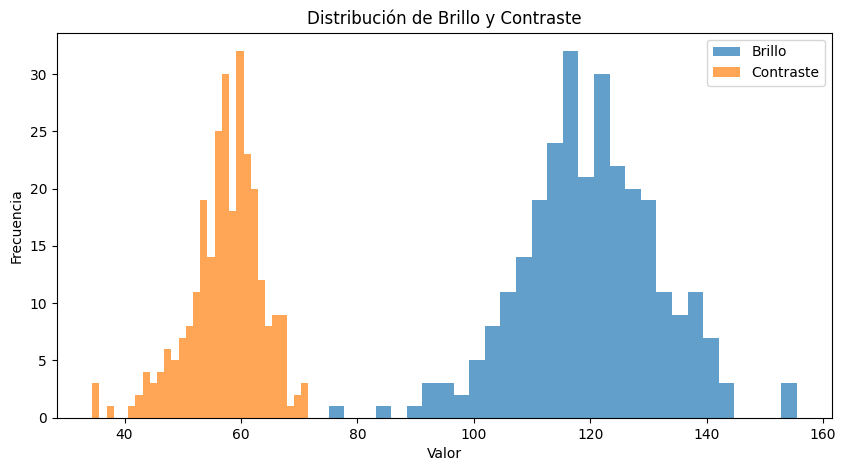

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Ruta al directorio del dataset
images_dir = './dataset/mydata/mydata/images/train'

# Funciones de análisis
def analyze_image(image_path):
    """Analiza propiedades de una imagen y retorna un diccionario con los resultados."""
    # Cargar imagen
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Dimensiones de la imagen
    height, width = gray.shape

    # Brillo promedio
    brightness = np.mean(gray)

    # Contraste (desviación estándar de los valores de intensidad)
    contrast = np.std(gray)

    # Histograma de color
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()

    # Ruido estimado (diferencia promedio entre la imagen y un filtro de suavizado)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    noise = np.mean(np.abs(gray - blurred))

    # Bordes detectados (Canny)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / (height * width)

    return {
        "Width": width,
        "Height": height,
        "Brightness": brightness,
        "Contrast": contrast,
        "Noise": noise,
        "Edge Density": edge_density
    }

# Analizar todas las imágenes
results = []
image_files = sorted(os.listdir(images_dir))

print("Analizando imágenes del dataset...")
for image_file in tqdm(image_files):
    image_path = os.path.join(images_dir, image_file)
    analysis = analyze_image(image_path)
    analysis["Image"] = image_file
    results.append(analysis)

# Convertir los resultados en un DataFrame
df = pd.DataFrame(results)

# Guardar el análisis como un archivo CSV
output_file = "image_analysis_summary.csv"
df.to_csv(output_file, index=False)

print(f"Análisis completado. Resumen guardado en {output_file}")

# Mostrar resumen estadístico
print("\nResumen Estadístico:")
print(df.describe())

# Visualizar histogramas de brillo y contraste
plt.figure(figsize=(10, 5))
plt.hist(df["Brightness"], bins=30, alpha=0.7, label="Brillo")
plt.hist(df["Contrast"], bins=30, alpha=0.7, label="Contraste")
plt.title("Distribución de Brillo y Contraste")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

Entrenando el modelo por medio de YOLOv5



In [5]:
# Descargando YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 24), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.69 MiB | 29.92 MiB/s, done.
Resolving deltas: 100% (11718/11718), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 17.7 MB/s eta 0:00:00


In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data /content/dataset/mydata128.yaml --weights yolov5s.pt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-01 05:02:58.508747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 05:02:58.529415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 05:02:58.535733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi

In [ ]:
!python val.py --weights runs/train/exp/weights/best.pt --data /content/dataset/mydata128.yaml --img 640

val: data=/content/dataset/mydata128.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/dataset/mydata/mydata/labels/test.cache... 19 images, 0 backgrounds, 0 corrupt: 100% 19/19 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:02<00:00,  2.12s/it]
                   all         19        459      0.993      0.983      0.992      0.807
Speed: 1.5ms pre-process, 29.6ms inference, 33.1ms NMS per image at shape (32, 3, 640, 640)

In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.5 --source /content/dataset/mydata/mydata/images/test

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/dataset/mydata/mydata/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/19 /content/dataset/mydata/mydata/images/test/1 (18)_1649990925.jpg: 544x640 8 cars, 38.8ms
image 2/19 /content/dataset/mydata/mydata/images/test/1 (4)_1649859559.jpg: 640x608 4 cars, 38.5ms
image 3/19 /content/dataset/mydata/mydata/images/test/1 (45)_1650423922.jpg: 512

# Modificación del dataset

1. Copiar las imagenes del dataset original modificadas a dataset_modified

In [6]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import shutil

# Directorios de entrada y salida
input_dirs = {
    "train": "/content/dataset/mydata/mydata/images/train",
    "test": "/content/dataset/mydata/mydata/images/test"
}
output_dirs = {
    "train": "/content/dataset_modified/mydata/mydata/images/train",
    "test": "/content/dataset_modified/mydata/mydata/images/test"
}
label_dirs = {
    "train": "/content/dataset/mydata/mydata/labels/train",
    "test": "/content/dataset/mydata/mydata/labels/test"
}
output_label_dirs = {
    "train": "/content/dataset_modified/mydata/mydata/labels/train",
    "test": "/content/dataset_modified/mydata/mydata/labels/test"
}

# Crear directorios de salida
for key in output_dirs:
    os.makedirs(output_dirs[key], exist_ok=True)
    os.makedirs(output_label_dirs[key], exist_ok=True)

# Funciones de modificación
def add_gaussian_noise(image, mean=0, stddev=25):
    """Añadir ruido gaussiano a una imagen."""
    noise = np.random.normal(mean, stddev, image.shape).astype('uint8')
    noisy_image = cv2.add(image, noise)
    return noisy_image

def adjust_brightness_contrast(image, alpha=1.5, beta=50):
    """Modificar el brillo y contraste de una imagen."""
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def apply_blur(image, ksize=(5, 5)):
    """Aplicar desenfoque gaussiano."""
    return cv2.GaussianBlur(image, ksize, 0)

def modify_image(image):
    """Aplicar una combinación de modificaciones a una imagen."""
    image = add_gaussian_noise(image)
    image = adjust_brightness_contrast(image, alpha=1.2, beta=30)
    image = apply_blur(image)
    return image

# Procesar imágenes y copiar etiquetas
print("Modificando imágenes y copiando etiquetas...")
for subset in input_dirs:
    input_dir = input_dirs[subset]
    output_dir = output_dirs[subset]
    input_label_dir = label_dirs[subset]
    output_label_dir = output_label_dirs[subset]

    # Procesar imágenes
    for file_name in tqdm(os.listdir(input_dir)):
        input_path = os.path.join(input_dir, file_name)
        output_path = os.path.join(output_dir, file_name)

        # Leer imagen
        image = cv2.imread(input_path)

        if image is None:
            print(f"No se pudo leer {file_name}, saltando.")
            continue

        # Modificar imagen
        modified_image = modify_image(image)

        # Guardar imagen modificada
        cv2.imwrite(output_path, modified_image)

    # Copiar etiquetas
    for label_name in os.listdir(input_label_dir):
        shutil.copy(
            os.path.join(input_label_dir, label_name),
            os.path.join(output_label_dir, label_name)
        )

print("Modificaciones completadas. Imágenes y etiquetas guardadas en los directorios correspondientes.")

Modificando imágenes y copiando etiquetas...


100%|██████████| 19/19 [00:02<00:00,  6.40it/s]


Modificaciones completadas. Imágenes y etiquetas guardadas en los directorios correspondientes.


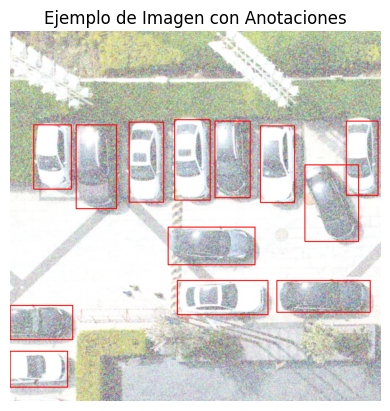

In [25]:
import cv2
import matplotlib.pyplot as plt
import os

train_images_modified_dir = '/content/dataset_modified/mydata/mydata/images/train'
train_labels_modified_dir = '/content/dataset_modified/mydata/mydata/labels/train'

# Listar imágenes y etiquetas
train_image_modified_files = sorted(os.listdir(train_images_modified_dir))
train_label_modified_files = sorted(os.listdir(train_labels_modified_dir))

# Cargar una imagen de muestra
# The original code was passing the list of file names as the first argument to os.path.join.
# It should instead pass the directory path.
sample_image_modified_path = os.path.join(train_images_modified_dir, train_image_modified_files[0])
sample_label_modified_path = os.path.join(train_labels_modified_dir, train_label_modified_files[0])

# Leer la imagen
image = cv2.imread(sample_image_modified_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Leer la etiqueta (formato YOLO)
# The original code was using a variable 'sample_label_path' that was not defined.
# It should use 'sample_label_modified_path' instead.
with open(sample_label_modified_path, 'r') as f:
    labels = f.readlines()

# Dibujar las cajas delimitadoras
h, w, _ = image.shape
for label in labels:
    class_id, x_center, y_center, width, height = map(float, label.strip().split())
    x1 = int((x_center - width / 2) * w)
    y1 = int((y_center - height / 2) * h)
    x2 = int((x_center + width / 2) * w)
    y2 = int((y_center + height / 2) * h)
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Mostrar la imagen con las cajas
plt.imshow(image)
plt.axis('off')
plt.title("Ejemplo de Imagen con Anotaciones")
plt.show()

2. Análisis de las Imágenes modificadas

Analizando imágenes del dataset modificado...


100%|██████████| 280/280 [00:06<00:00, 43.58it/s]


Análisis completado. Resumen guardado en image_analysis_modified_summary.csv

Resumen Estadístico:
             Width       Height  Brightness    Contrast       Noise  \
count   280.000000   280.000000  280.000000  280.000000  280.000000   
mean   1336.228571  1127.475000  220.409550   29.814251   88.569000   
std     171.704917   126.949484    6.697275    3.092488    7.387197   
min     881.000000   806.000000  195.696482   17.747558   67.952726   
25%    1211.000000  1038.000000  216.329458   28.274896   84.110904   
50%    1345.000000  1119.000000  219.936077   30.354523   89.282573   
75%    1468.000000  1221.000000  224.291159   31.863568   93.366992   
max    1733.000000  1444.000000  242.029201   38.854623  108.416356   

       Edge Density  
count    280.000000  
mean       0.057101  
std        0.018108  
min        0.011514  
25%        0.046280  
50%        0.056971  
75%        0.070083  
max        0.109587  


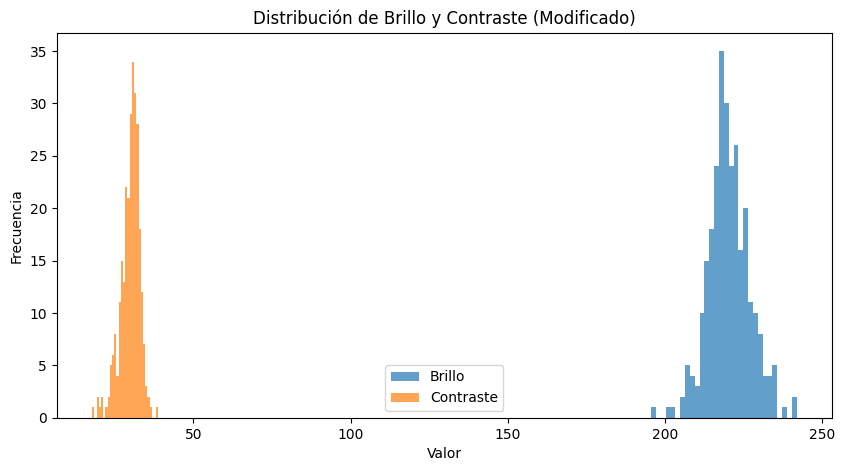

In [7]:
import cv2
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Ruta al directorio del dataset modificado
images_dir = '/content/dataset_modified/mydata/mydata/images/train'

# Funciones para análisis
def analyze_image(image_path):
    """Analiza propiedades de una imagen y retorna un diccionario con los resultados."""
    # Cargar imagen
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Dimensiones de la imagen
    height, width = gray.shape

    # Brillo promedio
    brightness = np.mean(gray)

    # Contraste (desviación estándar de los valores de intensidad)
    contrast = np.std(gray)

    # Ruido estimado (diferencia promedio entre la imagen y un filtro de suavizado)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    noise = np.mean(np.abs(gray - blurred))

    # Bordes detectados (Canny)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / (height * width)

    return {
        "Width": width,
        "Height": height,
        "Brightness": brightness,
        "Contrast": contrast,
        "Noise": noise,
        "Edge Density": edge_density
    }

# Analizar todas las imágenes
results = []
image_files = sorted(os.listdir(images_dir))

print("Analizando imágenes del dataset modificado...")
for image_file in tqdm(image_files):
    image_path = os.path.join(images_dir, image_file)
    analysis = analyze_image(image_path)
    analysis["Image"] = image_file
    results.append(analysis)

# Convertir los resultados en un DataFrame
df = pd.DataFrame(results)

# Guardar el análisis como un archivo CSV
output_file = "image_analysis_modified_summary.csv"
df.to_csv(output_file, index=False)

print(f"Análisis completado. Resumen guardado en {output_file}")

# Mostrar resumen estadístico
print("\nResumen Estadístico:")
print(df.describe())

# Visualizar histogramas de brillo y contraste
plt.figure(figsize=(10, 5))
plt.hist(df["Brightness"], bins=30, alpha=0.7, label="Brillo")
plt.hist(df["Contrast"], bins=30, alpha=0.7, label="Contraste")
plt.title("Distribución de Brillo y Contraste (Modificado)")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

3. Entrenamiento de YOLOv5

In [8]:
!python train.py --img 640 --batch 16 --epochs 50 --data /content/dataset_modified/mydata128.yaml --weights yolov5s.pt --name yolov5_modified

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-01 18:33:39.883124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 18:33:39.903665: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 18:33:39.910214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi


4. Validación del modelo creado

In [15]:
!python val.py --weights runs/train/yolov5_modified/weights/best.pt --data /content/dataset_modified/mydata128.yaml --img 640 --save-json --project runs/val --name yolov5_modified


val: data=/content/dataset_modified/mydata128.yaml, weights=['runs/train/yolov5_modified/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=yolov5_modified, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/dataset_modified/mydata/mydata/labels/test.cache... 19 images, 0 backgrounds, 0 corrupt: 100% 19/19 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:02<00:00,  2.52s/it]
                   all         19        459      0.989      0.977       0.99      0.777
Speed: 0.2ms pre-process, 20.7ms inference, 44.6ms

In [16]:
!python detect.py --weights runs/train/yolov5_modified/weights/best.pt --img 640 --conf 0.5 --source /content/dataset_modified/mydata/mydata/images/test --save-txt --save-conf --project runs/detect --name yolov5_modified


detect: weights=['runs/train/yolov5_modified/weights/best.pt'], source=/content/dataset_modified/mydata/mydata/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolov5_modified, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/19 /content/dataset_modified/mydata/mydata/images/test/1 (18)_1649990925.jpg: 544x640 8 cars, 38.2ms
image 2/19 /content/dataset_modified/mydata/mydata/images/test/1 (4)_1649859559.jpg: 640x608 4 ca

# Comparación entre modelos

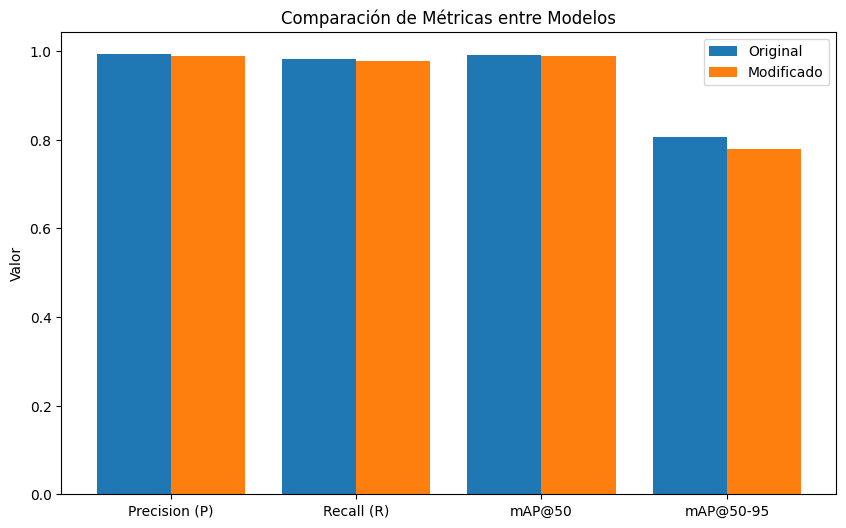

In [13]:
import matplotlib.pyplot as plt

# Datos de métricas
metrics = ['Precision (P)', 'Recall (R)', 'mAP@50', 'mAP@50-95']
original = [0.993, 0.983, 0.992, 0.807]  # Dataset original
modified = [0.989, 0.977, 0.99, 0.779]  # Dataset modificado

# Gráfico comparativo
x = range(len(metrics))
plt.figure(figsize=(10, 6))
plt.bar(x, original, width=0.4, label='Original', align='center')
plt.bar([p + 0.4 for p in x], modified, width=0.4, label='Modificado', align='center')
plt.xticks([p + 0.2 for p in x], metrics)
plt.title('Comparación de Métricas entre Modelos')
plt.ylabel('Valor')
plt.legend()
plt.show()


In [17]:
import glob

# Ruta a los archivos de texto generados
label_files = glob.glob('runs/detect/yolov5_modified/labels/*.txt')

confidences = []

for file in label_files:
    with open(file, 'r') as f:
        for line in f:
            confidences.append(float(line.strip().split()[-1]))  # Último valor es la confianza

print("Confianza (ejemplo):", confidences[:10])


Confianza (ejemplo): [0.849834, 0.90117, 0.902885, 0.903934, 0.908866, 0.909727, 0.910417, 0.911157, 0.911988, 0.914773]


<ipython-input-18-e70aba395d7e>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Modelo', y='Confianza', palette='Set2')


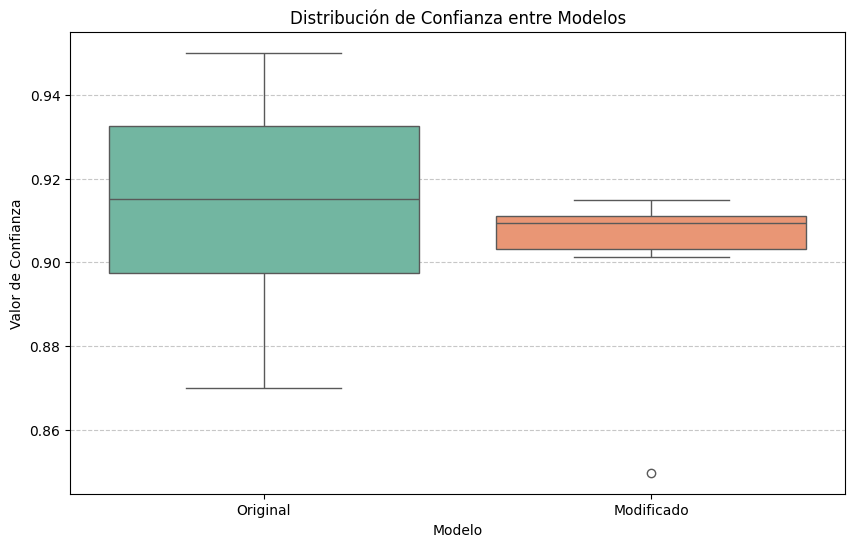

In [18]:
import pandas as pd
import seaborn as sns

# Simular valores de confianza
confidence_original = [0.9, 0.95, 0.92, 0.87, 0.91, 0.93, 0.89, 0.94]  # Valores reales
confidence_modified = [0.849834, 0.90117, 0.902885, 0.903934, 0.908866, 0.909727, 0.910417, 0.911157, 0.911988, 0.914773]

# Crear un DataFrame para el gráfico
df = pd.DataFrame({
    'Confianza': confidence_original + confidence_modified,
    'Modelo': ['Original'] * len(confidence_original) + ['Modificado'] * len(confidence_modified)
})

# Graficar
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Modelo', y='Confianza', palette='Set2')
plt.title('Distribución de Confianza entre Modelos')
plt.ylabel('Valor de Confianza')
plt.xlabel('Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()